# Part 1 : DICOM Image visualization and Alpha Fusion
Ikram Ul Haq

In [1]:
import os
import pydicom
import matplotlib.cm as cm
from matplotlib import animation
from tqdm import tqdm
import matplotlib.patches as mpatches

from utils import *

In [2]:
import os
print(os.getcwd())


C:\Users\iulhaq\Desktop\uib\2nd_semester\medical\project\medical-imaging-project


In [3]:
ct_images_path = "data_1/manifest-1715269027871-20240509T164701Z-001/manifest-1715269027871/HCC-TACE-Seg/HCC_013/08-16-1998-NA-ABDPELVIS-02874/5.000000-Recon 3 LIVER 3 PHASE AP-81040"
segmentation_image_path = "data_1/manifest-1715269027871-20240509T164701Z-001/manifest-1715269027871/HCC-TACE-Seg/HCC_013/08-16-1998-NA-ABDPELVIS-02874/300.000000-Segmentation-69940/1-1.dcm"

In [4]:
image_path = os.path.join(ct_images_path, os.listdir(ct_images_path)[0])
image = pydicom.dcmread(image_path)
print(image.pixel_array.shape)

(512, 512)


In [5]:
segmentation = pydicom.dcmread(segmentation_image_path)
segmentation.pixel_array.shape

(324, 512, 512)

Let's see some of the header information that will help us mapping of the slices in segmentation image and CT Image. Here we are analysing SOPInstance UID that is a unique identifier for each slice and it will be same for corresponding slices in CT image and segmentation image. We will use SOPInstanceUID for the mapping

In [6]:
frames = segmentation.PerFrameFunctionalGroupsSequence
print(frames[0].DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID)
print(frames[0].PlanePositionSequence[0].ImagePositionPatient)

1.3.6.1.4.1.14519.5.2.1.1706.8374.172741934018661566763726681611
[-2.097000e+02, -1.900000e+02, -2.480000e+02]


In the cell below, I am importing 3 data structures and here is the information about them.
- CTImage - This data structure will handle required headers information about a CT Image.
- SegmentationImage - This data structure will handle required headers information about a Segmentation Image.
- CTMapping - Will store one on one mapping of CTImage slices and SegmentationImage slices based on SOPInstanceUID.

In [7]:
from data_structures.ct_image import CTImage
from data_structures.segmentation_image import SegmentationImage
from data_structures.mapping import CTMapping

In [8]:
ct_image = CTImage()
ct_image.load_data(ct_images_path)
len(ct_image.slices)

81

In [9]:
ct_image.is_same_acquisition()

True

In [10]:
seg_image = SegmentationImage()
seg_image.load_data(segmentation_image_path)

In [11]:
mapping = CTMapping(ct_image, seg_image)
mapping.do_mapping()

for map in mapping.mappings[:10]:
    print(map[0].slice_location, map[0].sop_instance_uid, map[1].sop_instance_uid)


-248.000000 1.3.6.1.4.1.14519.5.2.1.1706.8374.172741934018661566763726681611 1.3.6.1.4.1.14519.5.2.1.1706.8374.172741934018661566763726681611
-245.500000 1.3.6.1.4.1.14519.5.2.1.1706.8374.972656146465711775875962924319 1.3.6.1.4.1.14519.5.2.1.1706.8374.972656146465711775875962924319
-243.000000 1.3.6.1.4.1.14519.5.2.1.1706.8374.580254454273976846705848353664 1.3.6.1.4.1.14519.5.2.1.1706.8374.580254454273976846705848353664
-240.500000 1.3.6.1.4.1.14519.5.2.1.1706.8374.113189674205485338455933580532 1.3.6.1.4.1.14519.5.2.1.1706.8374.113189674205485338455933580532
-238.000000 1.3.6.1.4.1.14519.5.2.1.1706.8374.627371788677255304485071662608 1.3.6.1.4.1.14519.5.2.1.1706.8374.627371788677255304485071662608
-235.500000 1.3.6.1.4.1.14519.5.2.1.1706.8374.658631976961277881616237787908 1.3.6.1.4.1.14519.5.2.1.1706.8374.658631976961277881616237787908
-233.000000 1.3.6.1.4.1.14519.5.2.1.1706.8374.188208772269508847259732540196 1.3.6.1.4.1.14519.5.2.1.1706.8374.188208772269508847259732540196
-230.5

In the cell above, Mapping is completed and we are printing information of mapping of CT slices and segmentation slices. We can see that SOPInstanceUID is same for each mapping and

In [12]:
mapping.image.shape

(81, 512, 512)

In [13]:
mapping.segmentations[3].shape

(81, 512, 512)

In the class, Pedro mentioned that image is upside down so we need to flip both CT image and segmentation to correct the orientation.

In [14]:
mapping.correct_orientation()

Let's plot some slices from the CT image.

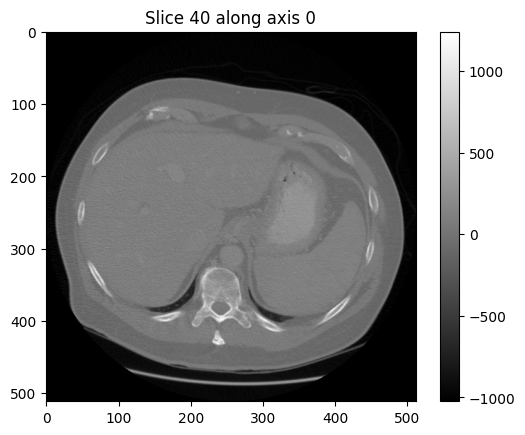

In [15]:
mapping.plot_image_slice(40, axis=0)

Let's plot a histogram and check the distribution of the CT image and perform windowing to improve the contrast.

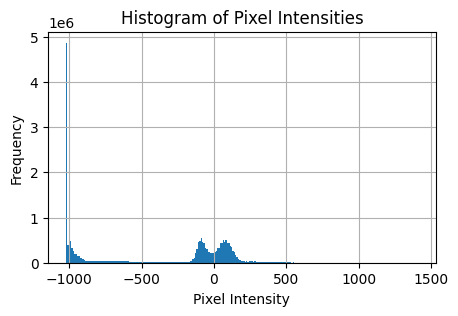

In [16]:
mapping.plot_histogram()

In [17]:
mapping.sigmoid_windowing(200, 1500)

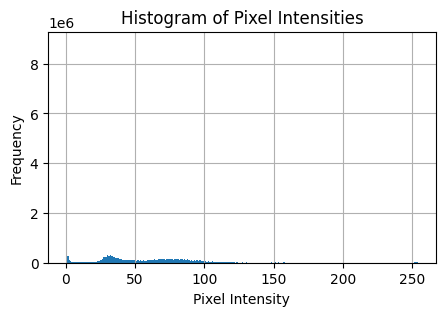

In [18]:
mapping.plot_histogram()

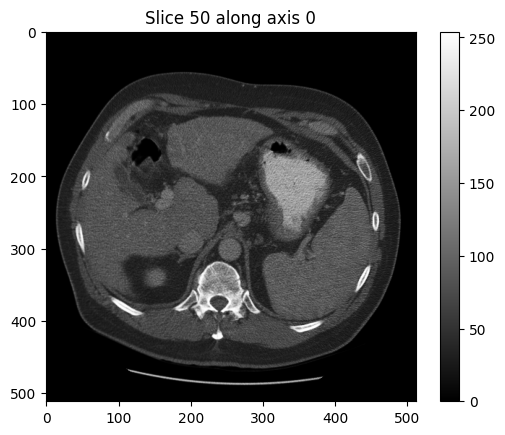

In [19]:
mapping.plot_image_slice(50, axis=0)

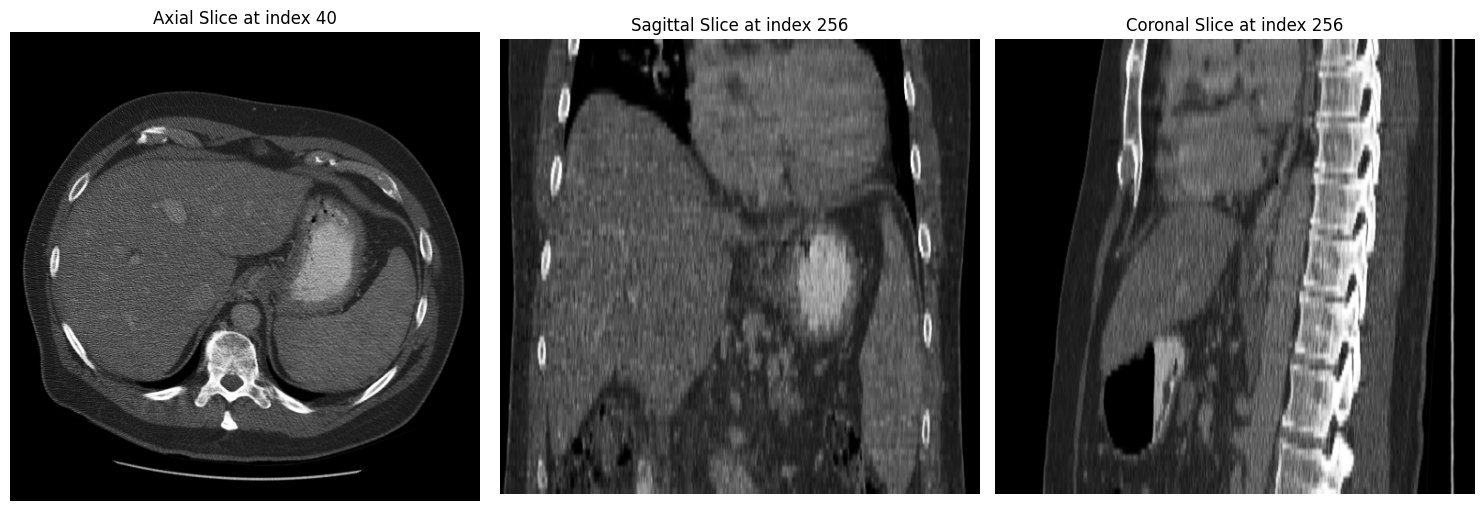

In [20]:
visualize_slices(mapping.image, 40, 256, 256, aspect=6)

Let's plot some slices from the CT image and it's corresponding segmentation slices.

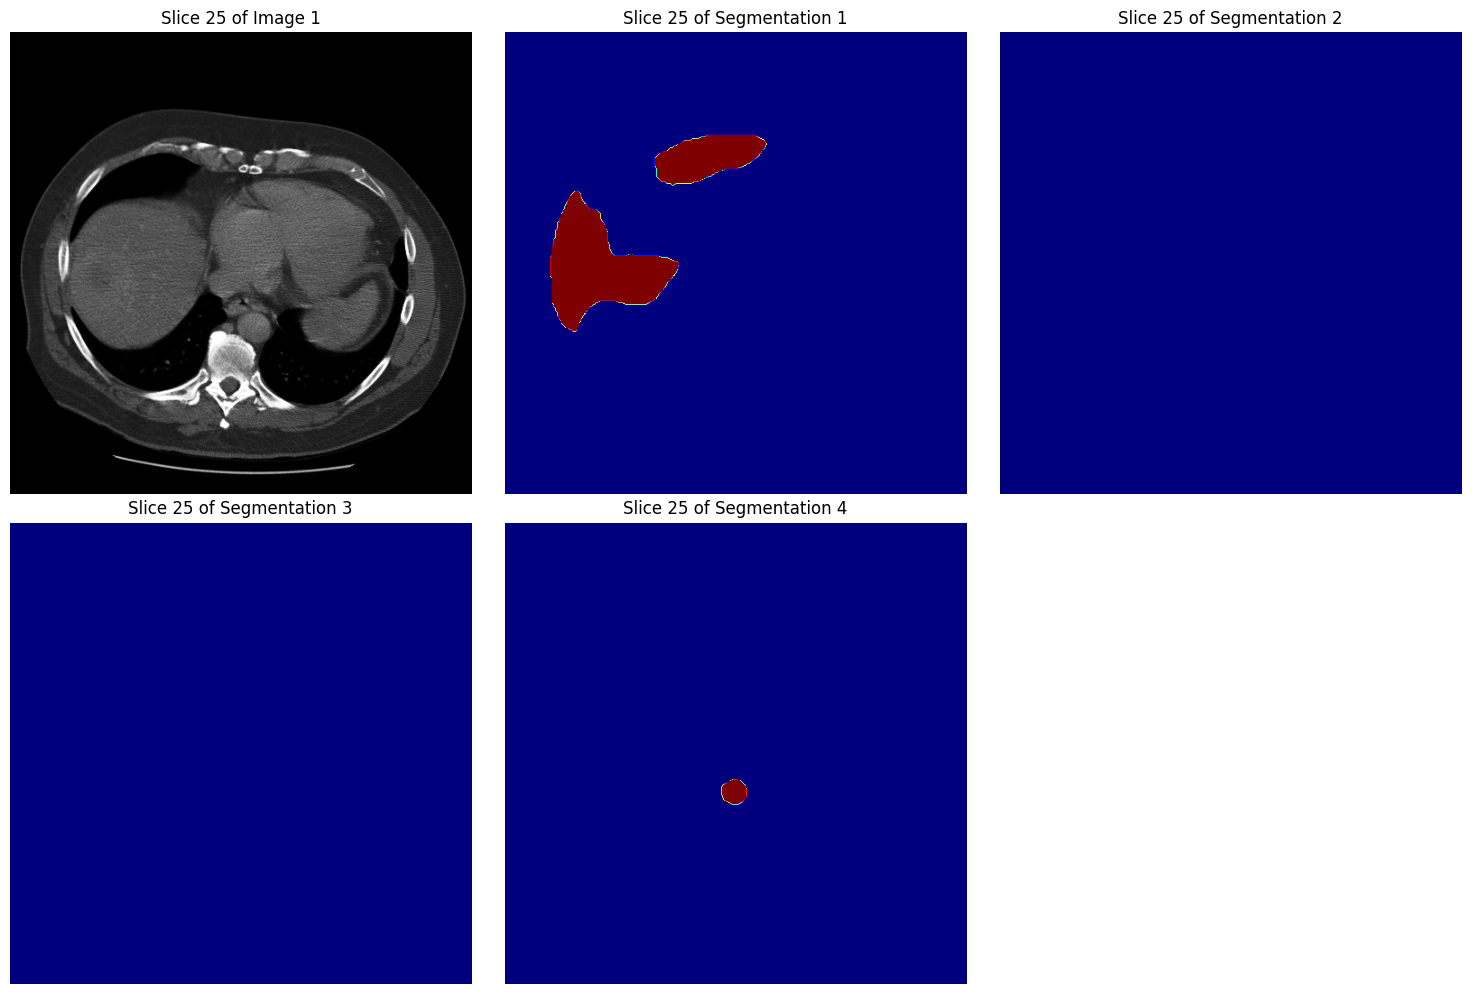

In [21]:
mapping.plot_image_slice_with_segments(25)

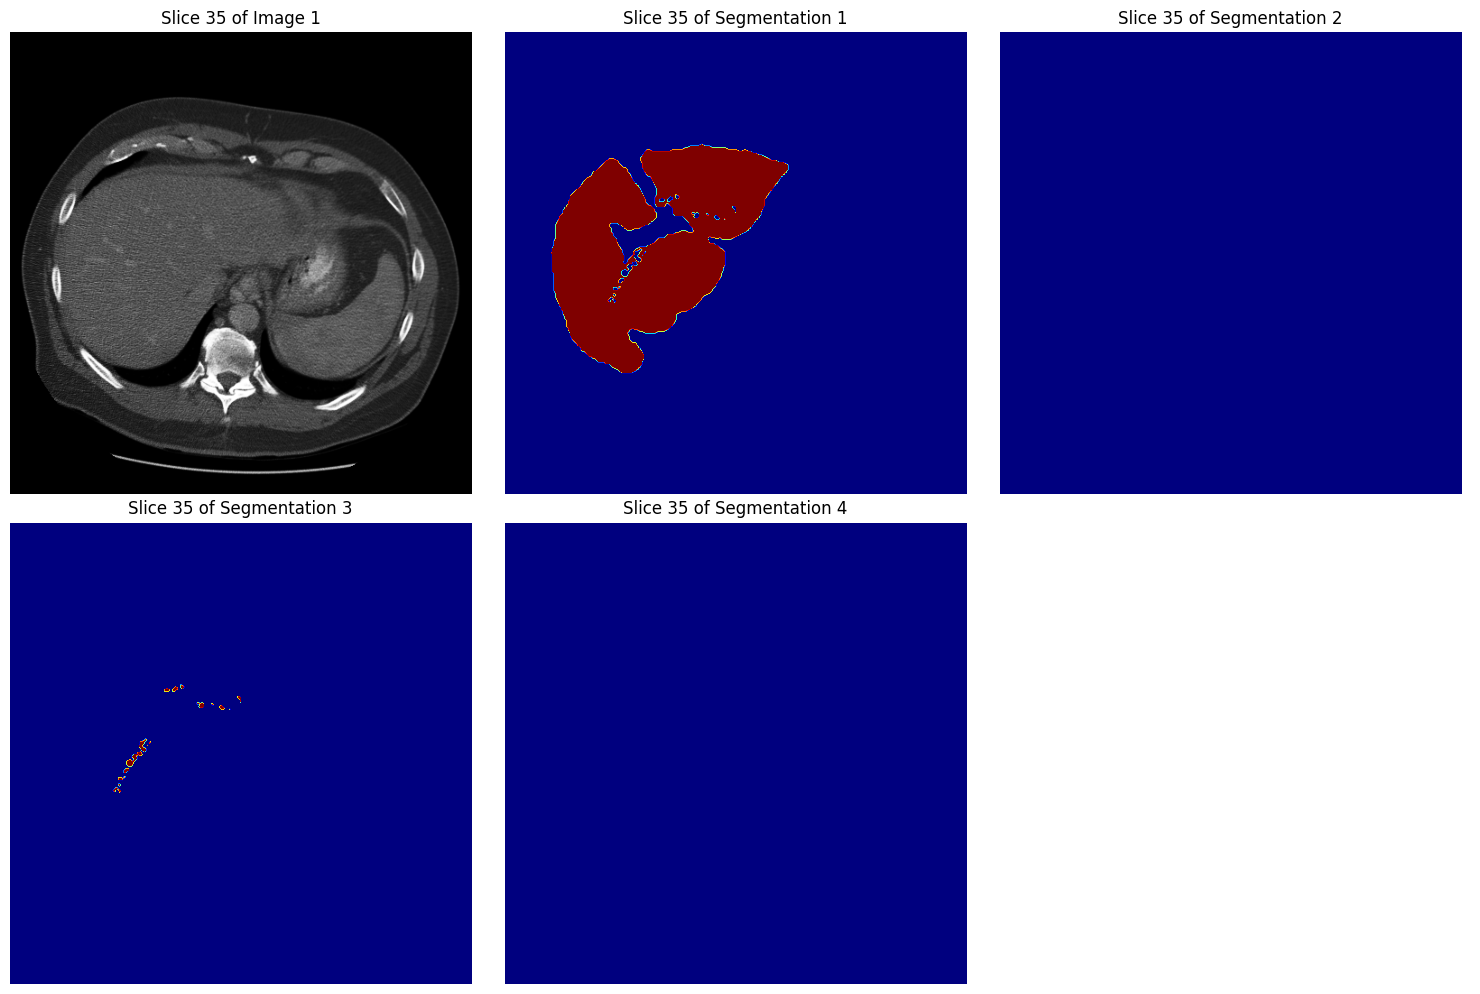

In [22]:
mapping.plot_image_slice_with_segments(35)

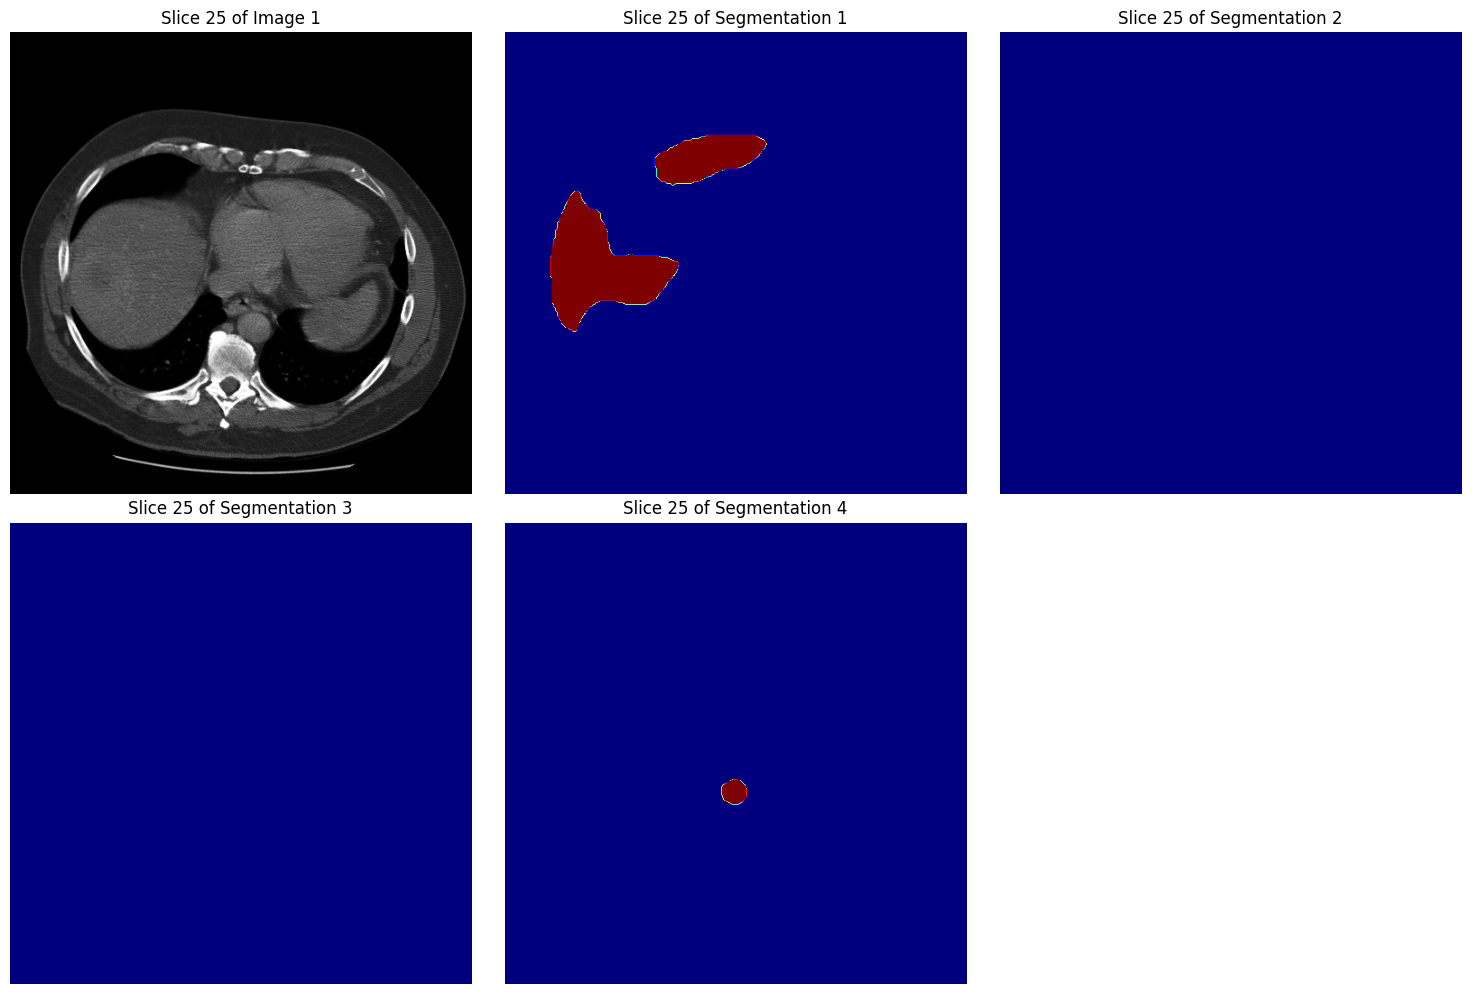

In [23]:
mapping.plot_image_slice_with_segments(25)

It turns out that we have correct mapping and both images are ready. we can now dive into alpha fusion to merge both image to highlight the part of image under study using segmentation.

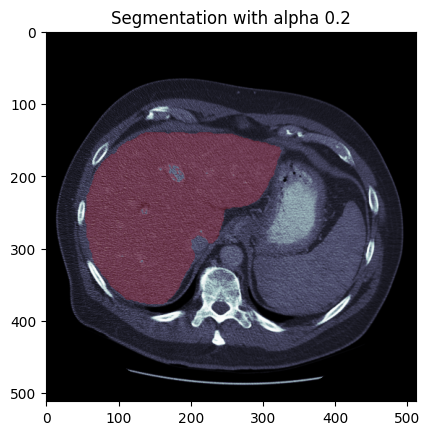

In [24]:
visualize_alpha_fusion(mapping.image[40], mapping.segmentations[0][40], alpha=0.2, visualize=True)

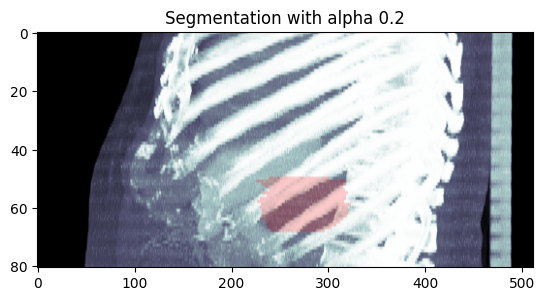

In [25]:
visualize_alpha_fusion(MIP_sagittal_plane(mapping.image), MIP_sagittal_plane(mapping.segmentations[1]), alpha=0.2, aspect=3, visualize=True)

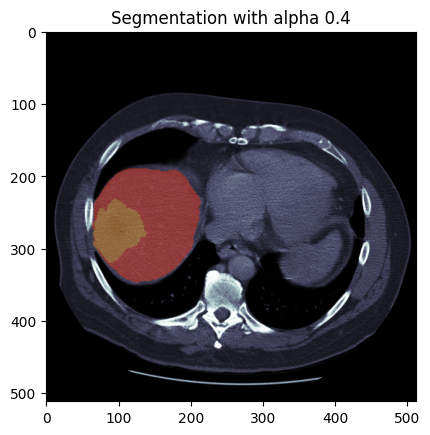

In [26]:
index=25
visualize_alpha_fusion(mapping.image[index], mapping.segmentation_image_combined[index], alpha=0.4, visualize=True)

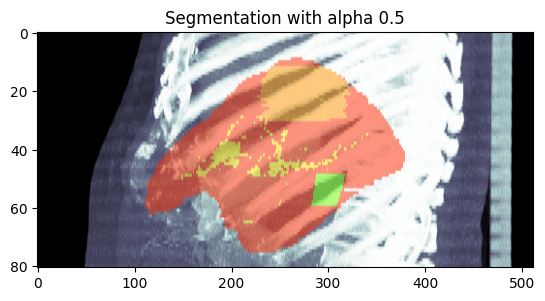

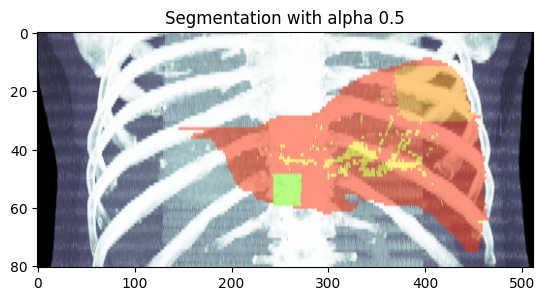

(81, 512, 512)
(81, 512, 512)


In [27]:
image = mapping.image
segmentation = mapping.segmentation_image_combined

visualize_alpha_fusion(MIP_sagittal_plane(img_dcm=image), MIP_sagittal_plane(segmentation), alpha=0.5, aspect=3, visualize=True)

rotated_img = rotate_on_axial_plane(image, 90)
rotated_seg = rotate_on_axial_plane(segmentation, 90)

visualize_alpha_fusion(MIP_sagittal_plane(img_dcm=rotated_img), MIP_sagittal_plane(rotated_seg), alpha=0.5, aspect=3, visualize=True)

print(image.shape)
print(segmentation.shape)

36it [03:31,  5.88s/it]
MovieWriter ffmpeg unavailable; using Pillow instead.


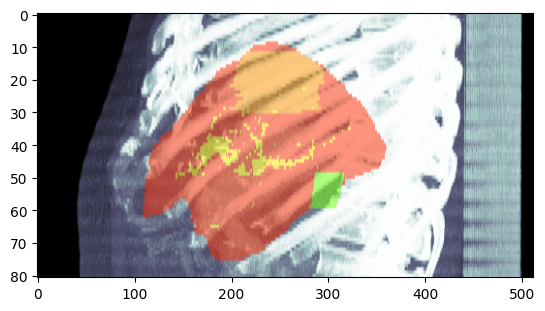

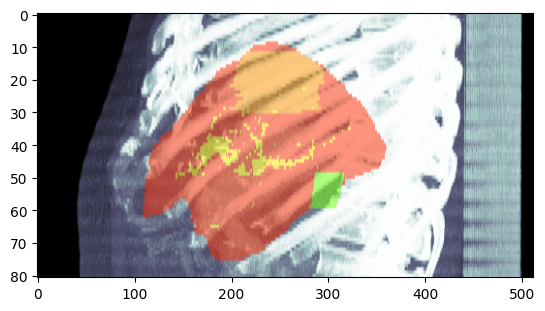

In [28]:
fig, ax = plt.subplots()
cm = matplotlib.colormaps.get_cmap('bone')

alpha = 0.5
n = 36
projections = []
slice_thickness = 2.5
pixel_spacing = [0.742188, 0.742188]

for i, angle in tqdm(enumerate(np.linspace(0, 360*(n-1)/n, num=n))):
    # Clear the current axes before plotting the next frame
    ax.clear()

    rotated_img = rotate_on_axial_plane(mapping.image, angle)
    rotated_seg = rotate_on_axial_plane(mapping.segmentation_image_combined, angle)

    projection_img = MIP_sagittal_plane(rotated_img)
    projection_seg = MIP_sagittal_plane(rotated_seg)

    projection = visualize_alpha_fusion(projection_img, projection_seg, alpha, visualize=False)
    ax.imshow(projection, aspect=slice_thickness / pixel_spacing[0], cmap=cm)
    plt.savefig(f'./projections/Projection_{i}.png')  # Save each frame as an image
    projections.append(projection)  # Save for later animation

fig, ax = plt.subplots()

animation_data = [
    [plt.imshow(img, animated=True, aspect=slice_thickness / pixel_spacing[0], cmap=cm)]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data, interval=250, blit=True, repeat_delay=1000)
anim.save('./animations/animation23.gif')  # Save animation
plt.show()  # Show animation
